In [52]:
import matplotlib.pyplot as plt
import mpl_lego as mplego
import numpy as np
import pandas as pd
import pickle

from functools import partial
from mpl_lego.labels import bold_text
from scipy.stats import bootstrap
from pyprojroot import here
from tqdm import tqdm

from moral_foundations_llms import keys
 
%matplotlib inline

In [2]:
mplego.style.use_latex_style()

In [3]:
df = pd.read_csv(here('data/aita_final_v29.csv'))

In [4]:
# Calculate bootstrap estimates
def label_difference(records, moral_scenario_label_col, model_verdict_col, aita_label):
    # Get the column indicating whether each row falls in the moral scenario
    scenario_moral_label = records[moral_scenario_label_col]
    # Get the column indicating what the model assigned that scenario as a verdict
    model_verdicts = records[model_verdict_col]
    # Moral scenario is true: what fraction of time did model assign the aita_label?
    scenario_true_prop = (model_verdicts[scenario_moral_label] == aita_label).mean()
    # Moral scenario is not true: what fraction of time did model assign the aita_label?
    scenario_false_prop = (model_verdicts[~scenario_moral_label] == aita_label).mean()
    # Calculate difference in proportions
    diff = scenario_true_prop - scenario_false_prop
    return diff

In [5]:
MORAL_SCENARIO_LABEL_COLS = [f'{moral_axis}_label' for moral_axis in keys.MORAL_AXES]

In [6]:
bounds = {moral_scenario_label_col:
          [[bootstrap((df[[moral_scenario_label_col, model_verdict_col]].to_records(index=False),),
          partial(label_difference,
                  moral_scenario_label_col=moral_scenario_label_col,
                  model_verdict_col=model_verdict_col,
                  aita_label=aita_label))
          # Calculate label difference for each AITA label
          for aita_label in keys.AITA_LABELS]
          # For each moral axis, calculate the label difference for the model
          for model_verdict_col in keys.LABEL_COLS]
          # Iterate over each moral axis
          for moral_scenario_label_col in tqdm(MORAL_SCENARIO_LABEL_COLS)}

  0%|                                                                                                 | 0/6 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/nlp/lib/python3.9/site-packages/scipy/stats/_resampling.py:147: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/opt/homebrew/Caskroom/miniforge/base/envs/nlp/lib/python3.9/site-packages/scipy/stats/_resampling.py:100: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  warnings.warn(DegenerateDataWarning(msg))
 17%|██████████████▋                                                                         | 1/6 [07:20<36:42, 440.50s/it]/opt/homebrew/Caskroom/miniforge/base/envs/nlp/lib/python3.9/site-packages/scipy/stats/_resampling.py:147: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/opt/homebr

In [54]:
with open('scenarios_bootstraps.pkl', 'wb') as file:
    pickle.dump(bounds, file)

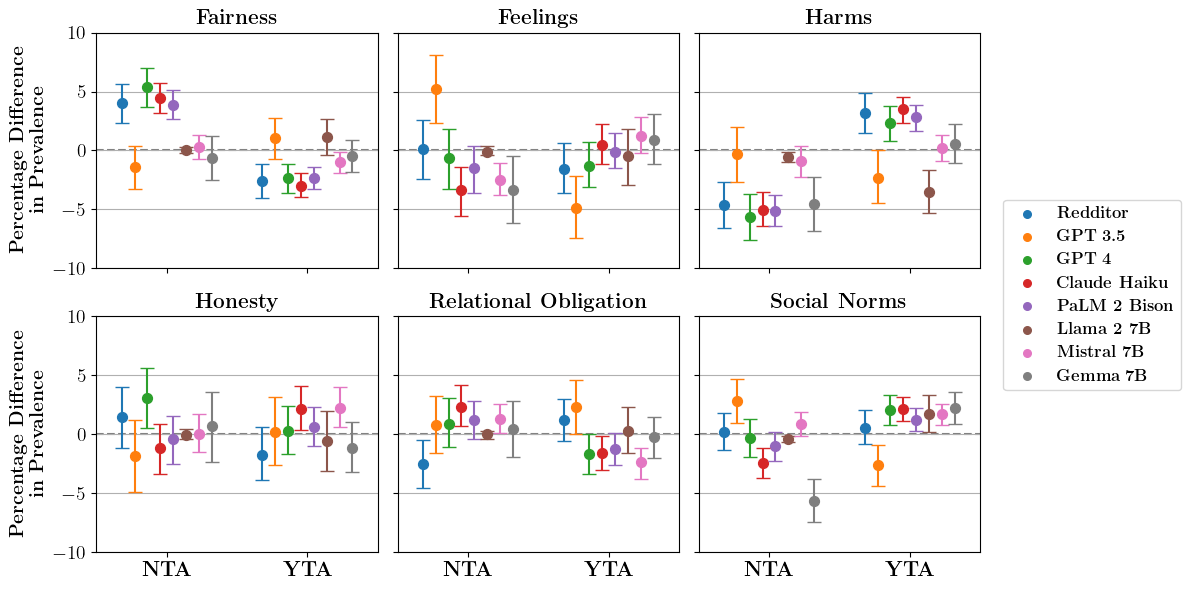

In [73]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)

jitter = np.linspace(-0.32, 0.32, 8)
axes_list = axes.ravel()

for moral_idx, (moral, bound) in enumerate(bounds.items()):
    for aita_idx in range(2):
        for model in range(len(keys.MODELS)):
            interval = bound[model][aita_idx]
            mean = 100 * interval.bootstrap_distribution.mean()
            low = 100 * interval.confidence_interval.low
            high = 100 * interval.confidence_interval.high
            axes_list[moral_idx].scatter(aita_idx + jitter[model], mean, color=f'C{model}', s=50)
            axes_list[moral_idx].errorbar(aita_idx + jitter[model], mean, yerr=[[mean - low], [high - mean]], capsize=5, color=f'C{model}')

            axes_list[moral_idx].set_title(bold_text(keys.MORAL_AXES_LABELS_PLOT[moral_idx]), fontsize=15)    

for idx, (model, model_label) in enumerate(zip(keys.MODELS, keys.MODEL_LABELS_PLOT)):
    axes[1, -1].scatter(-1, 0, color=f'C{idx}', label=bold_text(model_label), s=30)

fig.legend(loc='center left',
           bbox_to_anchor=(1.0, 0.5),
           prop={'size': 12},
           ncol=1)

for ax in axes_list:
    ax.set_ylim([-10, 10])
    ax.set_xticks([0, 1])
    ax.set_xlim([-0.5, 1.5])
    ax.axhline(0, linestyle='--', color='gray', zorder=-10000)
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    ax.set_xticklabels(bold_text(['NTA', 'YTA']), fontsize=15)
    ax.set_yticks([-10, -5, 0, 5, 10])

for ax in axes[:, 0]:
    ax.set_ylabel(bold_text('Percentage Difference\nin Prevalence'), fontsize=14)
    ax.set_yticklabels(['$-10$', '$-5$', '$0$', '$5$', '$10$'], fontsize=14)

plt.tight_layout()
plt.savefig('scenarios.pdf', bbox_inches='tight')